In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def load_mnist(batch_size = 64):
    train_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = True,
        transform = transform
    )
    test_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = False,
        transform = transform
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    
    return train_data, test_data, train_loader, test_loader

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad() #reset the gradients of model parameters
        loss.backward() #backprapagation
        optimizer.step() #adjust the parameters by the gradients collected in the backward pass
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X) #精確取值
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {test_loss:>8f} \n")
        

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [4]:

train_data, test_data, train_loader, test_loader= load_mnist()

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]

<Figure size 800x800 with 0 Axes>

In [5]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
summary(model, input_size = (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  262,656
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 10]                   5,130
│    └─ReLU: 2-6                         [1, 10]                   --
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.68
Estimated Total Size (MB): 2.69

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
epochs = 1

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    c_hist = train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print('Done!')

Epoch 1
-----------------------------------
loss: 0.316614 [    0/60000]
loss: 0.305168 [ 6400/60000]
loss: 0.214774 [12800/60000]
loss: 0.308995 [19200/60000]
loss: 0.581353 [25600/60000]
loss: 0.543203 [32000/60000]
loss: 0.170316 [38400/60000]
loss: 0.325572 [44800/60000]
loss: 0.295927 [51200/60000]
loss: 0.251389 [57600/60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.005393 

Done!


In [ ]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
import cv2 as cv


def img_to_torch(img):
    rows, cols = 28, 28
    img = cv.resize(img, (rows, cols), interpolation = cv.INTER_LINEAR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for row in range(rows):
        for col in range(cols):
            img[row, col] = (255 - img[row, col])
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.type(torch.FloatTensor)/255
    img = img.permute(0, 1, 2)
    return img

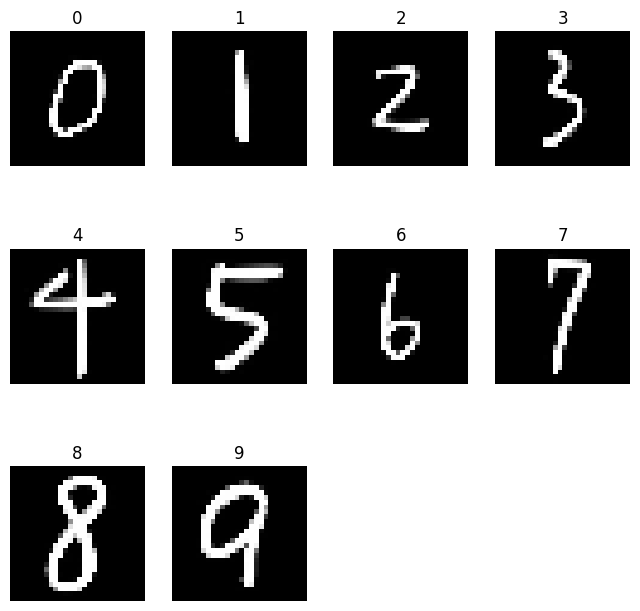

In [ ]:
figure = plt.figure(figsize=(8, 8))
handwrite_list = [[]]
for i in range(0, 10):
    figure.add_subplot(3, 4, i+1)
    img = cv.imread(f"data/handwrite/{i}.jpg")
    img = img_to_torch(img)
    handwrite_list.append([img, i])
    plt.title(i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = 'gray')
del handwrite_list[0]
plt.show()

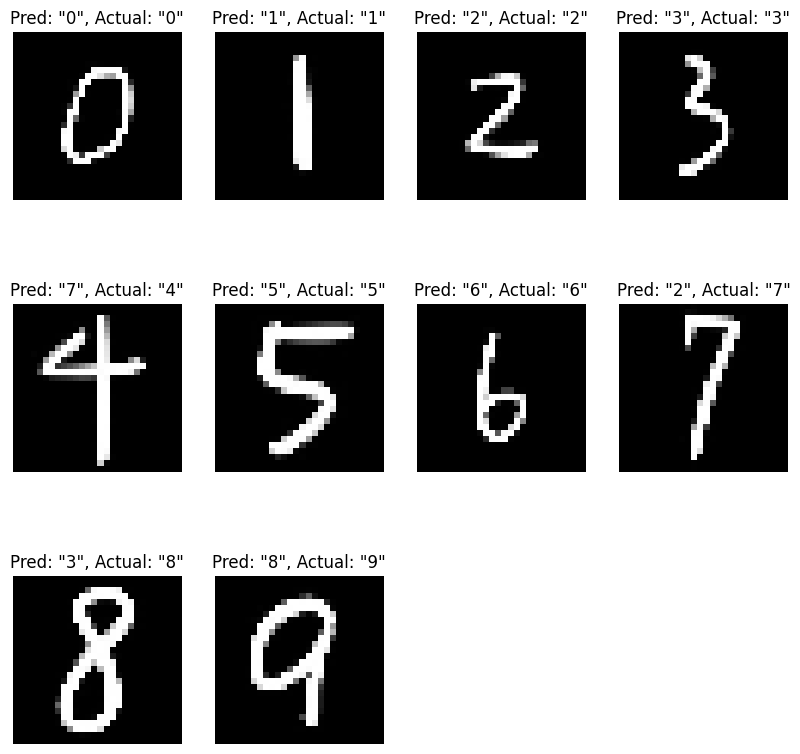

In [ ]:
model.eval()
figure1 = plt.figure(figsize=(10, 10))
for i in range(0, 10):
    figure1.add_subplot(3, 4, i+1)
    x, y = handwrite_list[i][0], handwrite_list[i][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = pred[0].argmax(0), y
        img, label = handwrite_list[i]
        plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap = "gray")
plt.show()
    